# Lecture 24 Demos

In [12]:
import numpy as np
from IPython.display import Audio
import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 14

## Demo 1: the comb filter

The transfer function of the comb filter with delay $K$ and gain $g$ is 

$$
Q(z) = \frac{z^K}{z^K - g}
$$


Let's plot its frequency response:

In [2]:
def comb_freq_response(ω, K, g):
    return np.exp(1j * ω * K) / (np.exp(1j * ω * K) - g)

In [3]:
omega_range = np.linspace(0, 10 * np.pi, 10000)

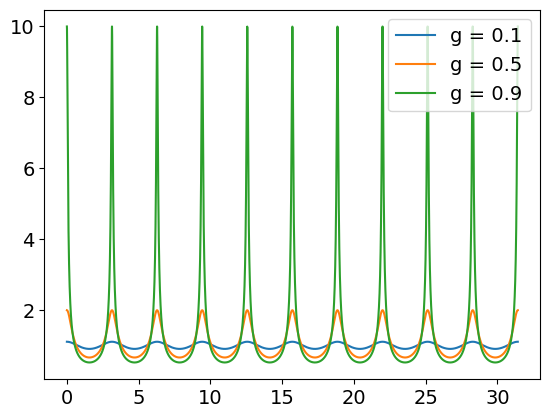

In [4]:
plt.plot(omega_range, np.abs(comb_freq_response(omega_range, 2, 0.1)), label="g = 0.1")
plt.plot(omega_range, np.abs(comb_freq_response(omega_range, 2, 0.5)), label="g = 0.5")
plt.plot(omega_range, np.abs(comb_freq_response(omega_range, 2, 0.9)), label="g = 0.9")
plt.legend()
plt.show()

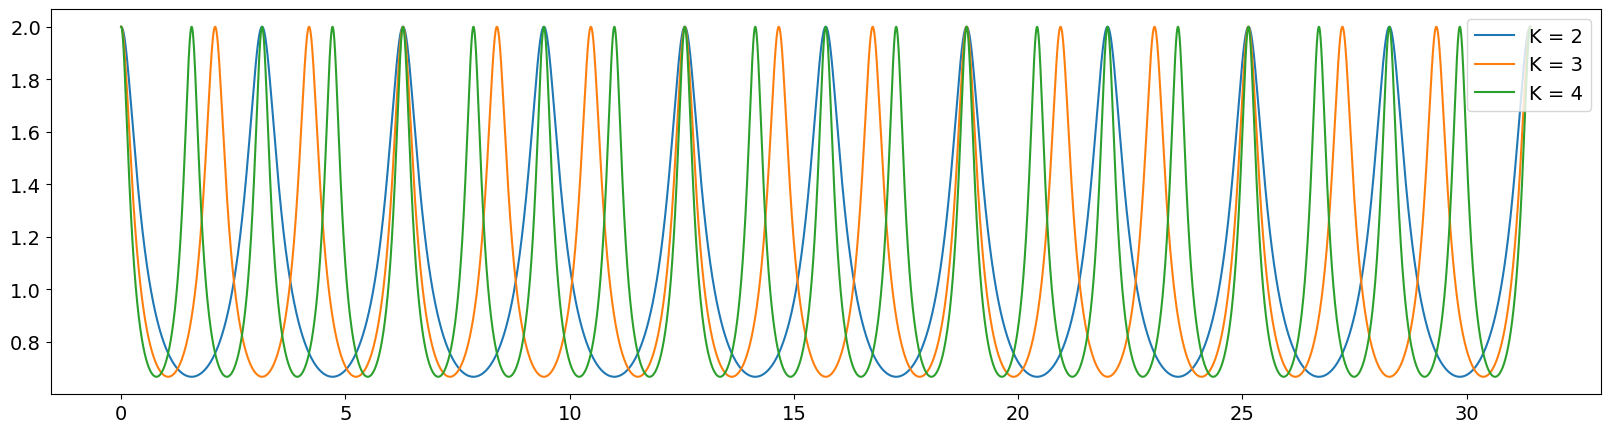

In [5]:
plt.figure(figsize=(20, 5))
plt.plot(omega_range, np.abs(comb_freq_response(omega_range, 2, 0.5)), label="K = 2")
plt.plot(omega_range, np.abs(comb_freq_response(omega_range, 3, 0.5)), label="K = 3")
plt.plot(omega_range, np.abs(comb_freq_response(omega_range, 4, 0.5)), label="K = 4")
plt.legend()
plt.show()

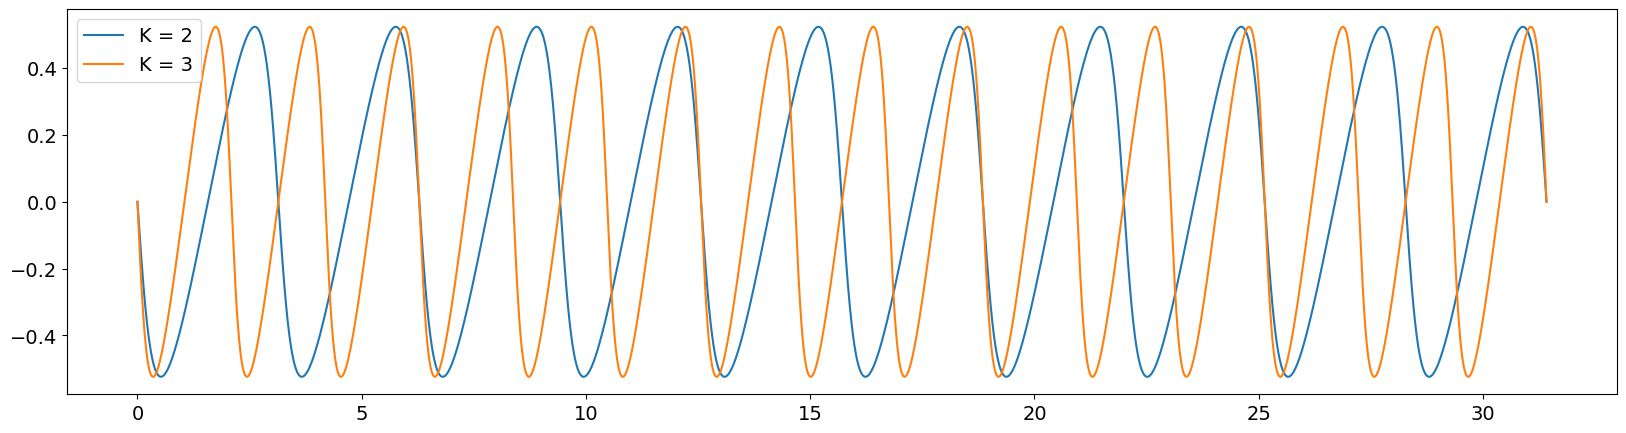

In [6]:
plt.figure(figsize=(20, 5))
plt.plot(omega_range, np.angle(comb_freq_response(omega_range, 2, 0.5)), label="K = 2")
plt.plot(omega_range, np.angle(comb_freq_response(omega_range, 3, 0.5)), label="K = 3")
plt.legend()
plt.show()

## Demo 2: Karplus-Strong

The transfer function of the Karplus-Strong algorithm is

$$
Q(z) = \frac{1}{1 - \frac{1}{2}(z^{-K} + z^{-K-1})}
$$

In [7]:
def karplus_strong_freq_response(ω, K, g=1):
    return 1 / (1 - 0.5 * g * np.exp(1j * ω * (-K)) - 0.5 * g * np.exp(1j * ω * (-K - 1)))

In [23]:
sample_rate = 48000
freqs = np.arange(1000)
omegas = 2 * np.pi * freqs / sample_rate

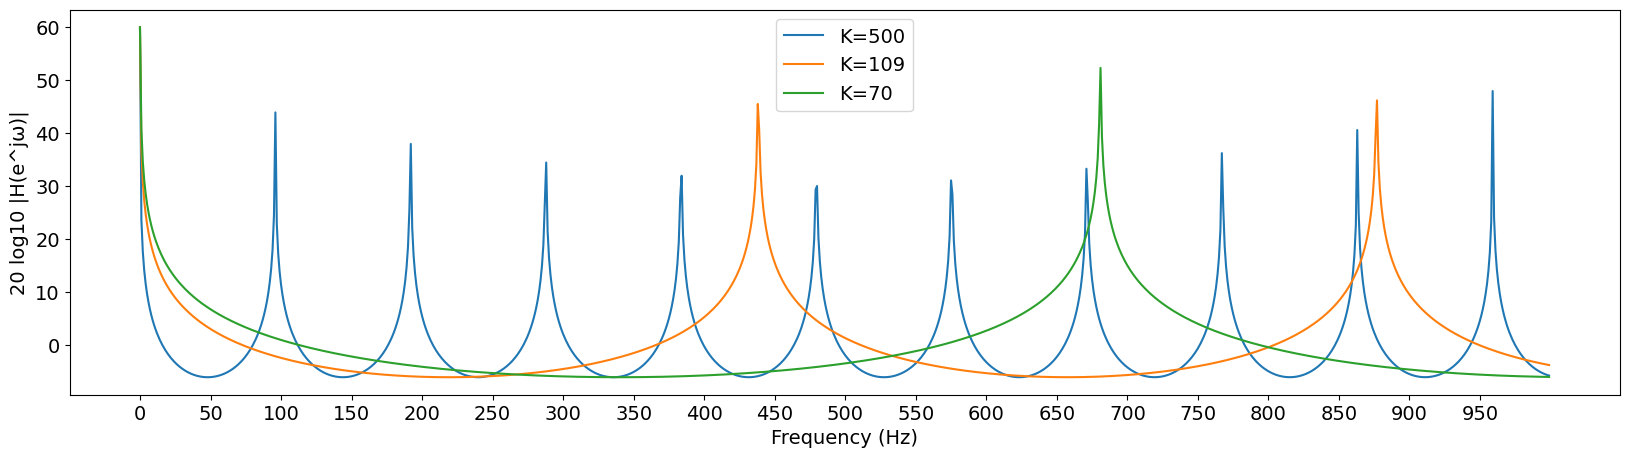

In [24]:
plt.figure(figsize=(20, 5))
plt.plot(freqs, 20 * np.log10(np.abs(karplus_strong_freq_response(omegas, 500, 0.999))), label="K=500")
plt.plot(freqs, 20 * np.log10(np.abs(karplus_strong_freq_response(omegas, 109, 0.999))), label="K=109")
plt.plot(freqs, 20 * np.log10(np.abs(karplus_strong_freq_response(omegas, 70, 0.999))), label="K=70")
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("20 log10 |H(e^jω)|")
plt.xticks(range(0, 1000, 50))
plt.show()

In [25]:
def noise_burst(N_samples, waveform_type="gaussian"):
    """Create a burst of white noise to initialize the Karplus-Strong algorithm.
              
    Use randomly-selected values between -1.0 and 1.0 according to the 
    following distributions:
      - Bernoulli w/p=0.5 (i.e., 1.0 or -1.0 with equal probability)
      - Uniform
      - Gaussian with mean 0
      
    Note that the data type of the random values must be a float, so be 
    sure to cast appropriately.
            
    Args:
        N_samples (int): The length of the sample.
        waveform_type (str): The type of random noise. Can be "bernoulli",
            "uniform", or "gaussian"
            
    Returns: 
        array[float]: The noise burst.            
    """
    if waveform_type == "bernoulli":
        return np.random.choice([-1.0, 1.0], size=N_samples)
    elif waveform_type == "uniform":
        return np.random.uniform(low=-1, high=1, size=N_samples)
    return np.random.normal(size=N_samples)

In [13]:
N_samples = 48000
Audio(noise_burst(N_samples, "bernoulli"), rate=sample_rate)

In [14]:
def karplus_strong(burst, num_feedback_loops=20, gain=0.996):
    """Implement the Karplus-Strong synthesis algorithm.
              
    Args:
        burst (array[float]): The initial noise burst.
        num_feedback_loops (int): The number of times to go through the feedback line.
        gain (float): The gain applied to the lowpass filter.
            
    Returns: 
        array[float]: The synthesized signal. It should have length 
        len(burst) * num_feedback_loops.
    """
    output_signal = np.zeros(len(burst) * num_feedback_loops, dtype=float)
    
    output_signal[:len(burst)] = burst
    
    ring_buffer = burst.copy()
    for loop_idx in range(1, num_feedback_loops):
        for el in range(len(burst)):
            ring_buffer[el] = gain * 0.5 * (ring_buffer[el] + ring_buffer[el-1])
        output_signal[loop_idx*len(burst):(loop_idx + 1)*len(burst)] = ring_buffer

    return output_signal

In [20]:
burst = noise_burst(440, "bernoulli")
ks_string = karplus_strong(burst, num_feedback_loops=100)
Audio(ks_string, rate=sample_rate)